# XGBoost (2) - SklearnWrapper

XGBoost 라이브러리를 sklearn과의 호환을 위해 Wrappering한 클래스

## #01. 패키지

In [14]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from matplotlib import pyplot as plt
from pandas import read_excel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# 성능향상
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

## #02. 데이터 로딩 및 전처리

In [15]:
# 데이터 로드
origin = read_excel("https://data.hossam.kr/G02/breast_cancer.xlsx")
# print(origin.info())
# origin.head()

# 독립/종속변수 분리
x = origin.drop('target', axis=1)
y = origin['target']
# x.shape, y.shape

# 데이터 스케일링
std_x = StandardScaler().fit_transform(x)

# 훈련/검증 데이터 분리(test_size 미지정시 자동 0.25)
x_train, x_test, y_train, y_test = train_test_split(std_x, y, random_state=2021)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426,), (143,))

### 데이터 불균형 처리

#### Over Sampling - SMOTE

소수 집단의 데이터를 바탕으로 새로운 데이터를 생성.

단순히 소수 집단의 데이터를 복원 추출하는 것이 아니라 소수 집단 데이터를 분석해 어떤 특징이 있는지 살피고 그와 유사한 패턴을 가지는 가짜 데이터를 생성.

##### `sampling_strategy 파라미터`

sampling_strategy : 2진 분류일 경우 실수로 설정 가능

| 값 | 설명 |
| -- | -- |
| `minority` | `소수 클래스만` 다시 샘플링 |
| `not majority` | `다수 아님` : 다수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `not minority` | `소수 아님` : 소수 클래스를 제외한 모든 클래스를 다시 샘플링 |
| `all` | `모든 클래스`를 다시 샘플링 |
| `auto` | 자동 처리 |

혹은 실수 타입으로 설정할 경우 샘플 수의 비율을 의미

##### `k_neighbors 파라미터 (int)`

합성 샘플을 생성하는데 사용할 샘플의 가장 가까운 이웃 수 (기본값=5)

In [16]:
# SMOTE 적용
x_sm, y_sm = SMOTE(random_state=2021).fit_resample(x_train, y_train)
x_sm.shape, x_test.shape, y_sm.shape, y_test.shape

((530, 30), (143, 30), (530,), (143,))

## #03. 훈련모델 구축

### XGBoost 전용 데이터 생성

sklearnwrapper에서는 전용 데이터를 생성할 필요가 없음.

> 기존의 DataFrame 형식을 사용 가능

### 학습 모델 적합

- `eta` 파라미터는 `learning_rate`로 이름이 변경
- `num_boost_round` 파라미터는 `n_estimator`로 이름이 변경
- sub_sample -> subsample
- lambda -> reg_lambda
- alpha -> reg_alpha

> 예측치를 산정할 경우 각 클래스에 속할 확률이 아니라 클래스의 분류 결과를 반환

In [17]:
# 모델 생성
xgb_model = XGBClassifier(n_estimator=400,
                          learning_rate = 0.1,
                          max_depth = 3
                          )
# 학습
xgb_model.fit(x_sm, y_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=400, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### 학습 결과 확인

In [18]:
# 예측치를 산정할 경우 각 클래스에 속할 확률이 아니라 클래스의 분류 결과를 반환
preds = xgb_model.predict(x_test)
print("predict() 수행 결과값을 10개만 표시, 분류 결과 값")
print(preds[:10])

print()

# 클래스에 속할 확률값(이진분류이므로 1에 속할 확률만 취함)
pred_probs = xgb_model.predict_proba(x_test)[:,1]
print("predict() 수행 결과값을 10개만 표시, 예측 확률 값")
print(pred_probs[:10])

predict() 수행 결과값을 10개만 표시, 분류 결과 값
[1 1 1 0 1 0 0 1 0 1]

predict() 수행 결과값을 10개만 표시, 예측 확률 값
[9.9415153e-01 9.8284322e-01 9.9651504e-01 8.9002063e-04 9.9269450e-01
 6.7870319e-03 7.0146541e-04 9.9319988e-01 3.0535446e-03 9.9932778e-01]


### 성능평가

#### 오차 행렬

In [19]:
confusion = confusion_matrix(y_test, preds)
confusion

array([[48,  3],
       [ 2, 90]], dtype=int64)

#### 성능지표 확인

In [20]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, pred_probs)
print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f},  F1 : {3:.4f}, AUC : {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

정확도 : 0.9650, 정밀도 : 0.9677, 재현율 : 0.9783,  F1 : 0.9730, AUC : 0.9966


### 변수별 중요도 확인

feature_names 미지정으로 이름을 알아보기 어려움

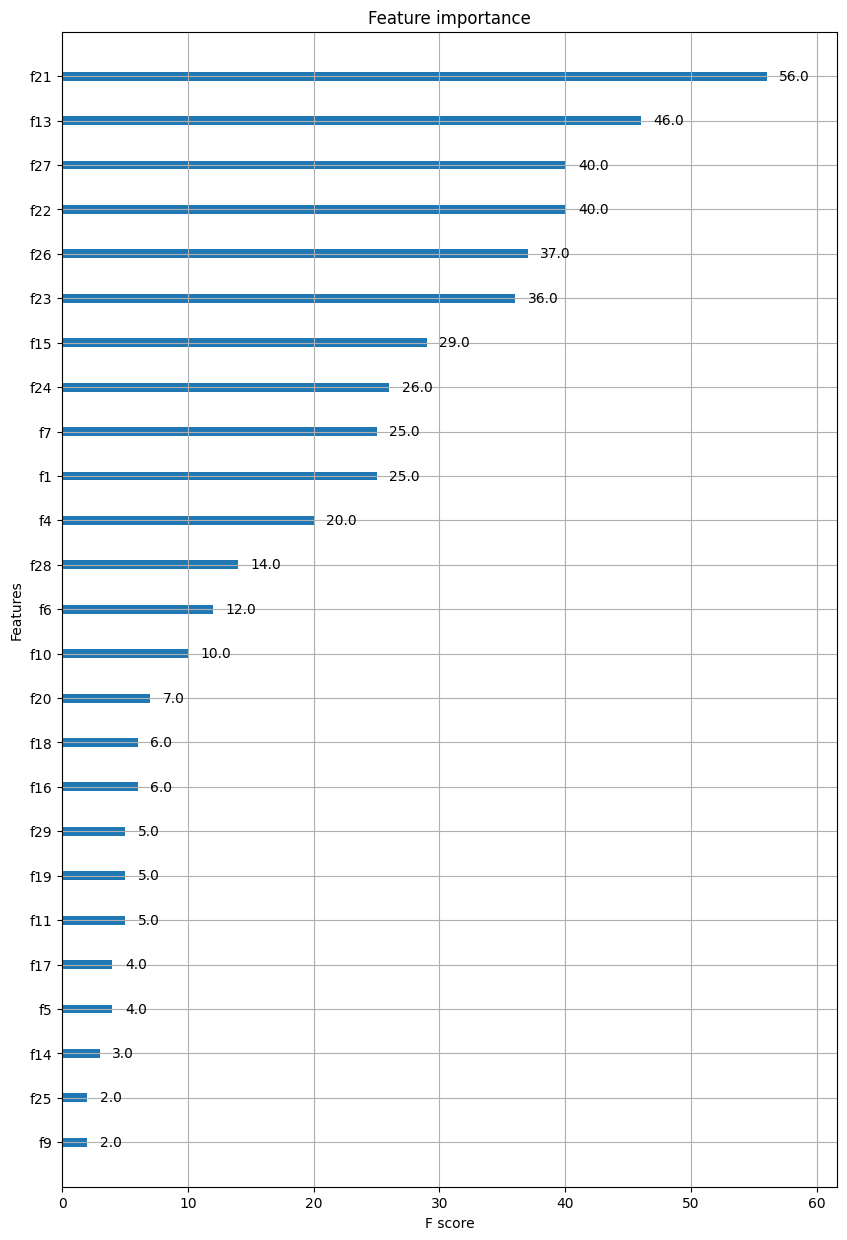

In [21]:
plt.figure(figsize=(10,15))
# xgb.DMatrix에서 feature_names 설정 안 하면 이름이 안 나와서 알아보기 어려움
plot_importance(xgb_model, ax=plt.gca())
plt.grid(True)
plt.show()
plt.close()

## #04. 하이퍼 파라미터 튜닝

최적의 하이퍼 파라미터 추출을 목표

### 모델 적합

#### `주요 일반 파라미터`

| 파라미터명 | 설명 |
| -- | -- |
| booster | gbtree(tree based model) 또는 gblinear(linear model) 선택, default는 gbtree |
| silent | default는 0이며, 출력 메세지를 나타내고 싶지 않을 경우 1로 설정 |
| nthread | CPU의 실행 스레드 개수를 조정하며, default는 CPU의 전체 스레드를 다 사용하는 것이다. <br/>멀티 코어/스레트 CPU 시스템에서 전체 CPU를 사용하지 않고 일부 CPU만 사용해 ML 애플리케이션을 구동하는경우에 변경 |

#### `주요 부스터 파라미터`

| 파라미터명 | 설명 |
| -- | -- |
| learning_rate (eta) | 학습률. <br/>0에서 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값기본 xgboost를 이용할 경우 default는 0.3이고 사이킷런 래퍼 클래스를 이용할 경우 eta는 learning_rate 파라미터로 대체되며, default는 0.1이다.
보통은 0.01 ~ 0.2 사이의 값을 선호 |
| n_estimators(num_boost_rounds) | 부스팅 반복 횟수 |
| min_child_weight | 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의
weight 총합, min_child_weight가 클수록 분할을 자제한다. 과적합을 조절하기위해 사용된다.(기본값=1) |
| min_split_loss(gamma) | 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값이다. <br/>해당 값보다 큰 손실(loss)이 감소된 경우에 리프 노드를 분리한다.
값이 클수록 과적합 감소 효과가 있다.(기본값=0) |
| max_depth | 트리 기반 알고리즘의 max_depth와 같다. <br/>0을 지정하면 깊이에 제한이 없다. <br/>max_depth가 높으면 특정 피쳐 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성이 높아지며 보통은 3~10 사이의 값을 적용(기본값=6) |
| sub_sample(subsample) | 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을지정한다. <br/>sub_sample=0.5로 지정하면 전체 데이터의 절반을 트리를 생성하는데 사용한다. <br/>0에서 1사이의 값이 가능하나 일반적으로 0.5 ~ 1 사이의 값을 사용(기본값=1) |
| colsample_bytree | GBM의 max_feature와 유사하다. <br/>트리 생성에 필요한 피처(column)를 임의로샘플링하는 데 사용된다. <br/>매우 많은 피처가 있는 경우 과적합을 조정하는 데 적용(default=1) |

#### `학습 태스크 파라미터`

##### `objective`

최솟값을 가져야할 손실 함수

| 함수 | 설명 |
| -- | -- |
| `binary:logitic` | 이진 분류일 때 적용한다. |
| `multi:softmax` | 다중 분류일 때 적용한다.<br/>손실함수가  `multi:softmax` 일 경우에는 label 클래스의 개수인 num_class parameter를 지정해야 한다. |
| `multi:softprob` | multi:softmax와 유사하나 개별 label 클래스의 해당되는 예측 확률을 반환한다. |

##### `eval_metric`

- 검증에 사용되는 함수를 정의.
- defalut는 회귀인 경우는  `rmse`, 분류일 경우에는 `error`이다.

In [22]:
xgb_model = XGBClassifier()

params = {
    'n_estimators':[300,400],
    "learning_rate":[0.05, 0.1, 0.15],
    'max_depth':[5,7]
}

# 모델 생성
grid = GridSearchCV(xgb_model, param_grid=params, scoring="accuracy", cv=5)
# 모델 학습
grid.fit(x_sm, y_sm)

print(grid.best_params_)
print(grid.best_score_)
best_model = grid.best_estimator_

print()

print(best_model)

print()

y_pred = best_model.predict(x_test)
print("최종 모델의 성능(테스트 데이터) :", accuracy_score(y_test,y_pred))

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 300}
0.9679245283018869

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

최종 모델의 성능(테스트 데이터) : 0.9790209790209791


#### 모델의 과적합 문제 해결

1. eta 값을 낮춘다. (`0.01 ~ 0.1`). 그리고 eta 값을 낮추면 num_round(또는 n_estimator)는 반대로 높여준다.
2. max_depth 값을 낮춘다.
3. min_child_weight 값을 높인다.
4. subsample과 cosample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 될 수 있다.

# 이후 과정은 ~37을 참고

- ### 성능 검증(분류 보고서, AUC/ROC 곡선)